In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# 1. Data Collection

In [2]:
data = pd.read_csv('heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
print(data.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [5]:
row_index = 5  # Replace 5 with the desired row number (starting from 0)
specific_row = data.iloc[row_index]
print(specific_row)

age          58.0
sex           0.0
cp            0.0
trestbps    100.0
chol        248.0
fbs           0.0
restecg       0.0
thalach     122.0
exang         0.0
oldpeak       1.0
slope         1.0
ca            0.0
thal          2.0
target        1.0
Name: 5, dtype: float64


#2. Data Preprocessing

# 2.1 Data Exploration
The dataset was thoroughly examined to ensure its integrity and readiness for analysis. Key steps included checking for missing values, verifying data types, and generating summary statistics. The dataset was found to be complete, with no missing entries, which facilitated a straightforward preprocessing workflow.

In [6]:
data.isnull().sum()


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## 2.2 Encoding Categorical Variables
Categorical variables, such as cp, restecg, slope, ca, and thal, were transformed using one-hot encoding. This process was essential for converting categorical data into a numerical format suitable for machine learning algorithms.

In [7]:
data = pd.get_dummies(data, columns=['cp', 'restecg', 'slope', 'ca', 'thal'])


In [8]:
print(data.columns)

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'target', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1',
       'restecg_2', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2',
       'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')


## 2.3 Feature Scaling
Numerical features, including age, trestbps, chol, thalach, and oldpeak, were standardized to ensure consistency in their scale. This step involved adjusting the features to have a mean of 0 and a standard deviation of 1, thereby enhancing the model's ability to learn effectively.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = scaler.fit_transform(data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])


In [10]:
data.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,-0.268437,1,-0.377636,-0.659332,0,0.821321,0,-0.060888,0,True,...,True,False,False,True,False,False,False,False,False,True
1,-0.158157,1,0.479107,-0.833861,1,0.255968,1,1.727137,0,True,...,False,True,False,False,False,False,False,False,False,True
2,1.716595,1,0.764688,-1.396233,0,-1.048692,1,1.301417,0,True,...,False,True,False,False,False,False,False,False,False,True
3,0.724079,1,0.936037,-0.833861,0,0.516900,0,-0.912329,0,True,...,True,False,True,False,False,False,False,False,False,True
4,0.834359,0,0.364875,0.930822,1,-1.874977,0,0.705408,0,True,...,False,False,False,False,True,False,False,False,True,False


## 2.4 Data Splitting
The preprocessed data was partitioned into training and testing sets using a stratified split. This method preserved the distribution of the target variable across the splits, ensuring that the model evaluation would be both reliable and representative of its performance on unseen data.

In [11]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Handling Class Imbalance
To address the issue of class imbalance in the dataset, the BorderlineSMOTE technique was employed. BorderlineSMOTE generates synthetic samples for the minority class, particularly focusing on the instances that lie on the borderline between classes. This method enhances the learning process for the model by concentrating on samples near the decision boundary, which are more challenging to classify. By generating more synthetic samples for these critical instances, BorderlineSMOTE helps the model better distinguish between classes and reduces the risk of bias toward the majority class. This approach is essential for improving the model's overall predictive performance and ensuring a more balanced representation of the data.



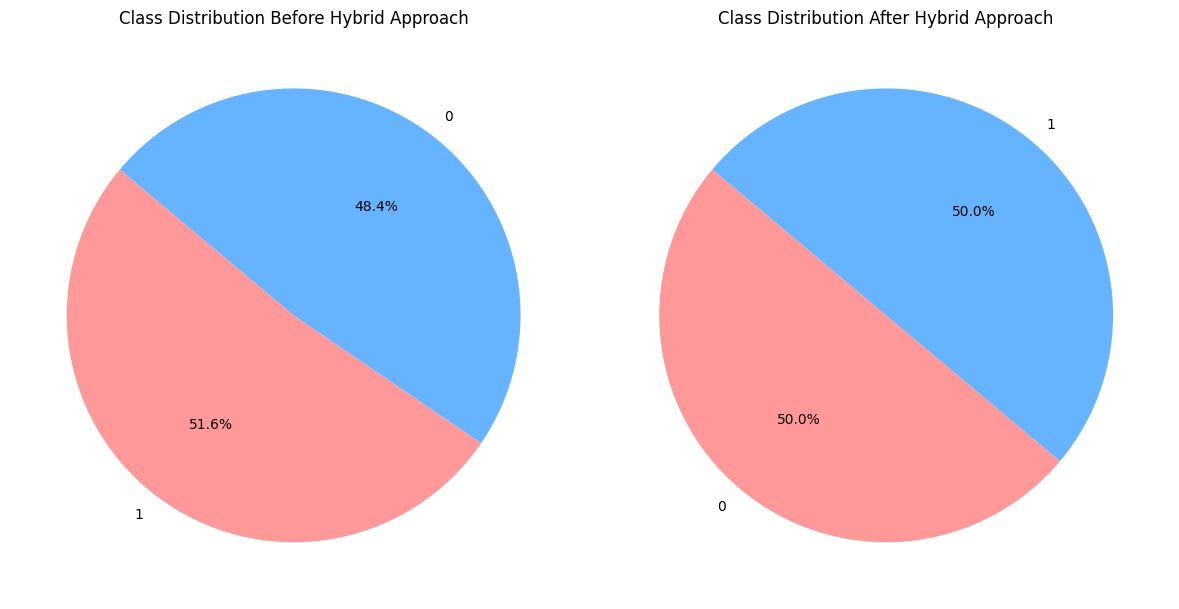

In [12]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks

# Initial class distribution
before_counts = y_train.value_counts()
before_labels = before_counts.index
before_sizes = before_counts.values

# Step 1: Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Step 2: Apply Borderline-SMOTE
borderline_smote = BorderlineSMOTE(sampling_strategy='all', k_neighbors=15, random_state=42)
X_borderline_smote, y_borderline_smote = borderline_smote.fit_resample(X_smote, y_smote)

# Step 3: Apply Tomek Links
tomek = TomekLinks(sampling_strategy='all')
X_final, y_final = tomek.fit_resample(X_borderline_smote, y_borderline_smote)

# Class distribution after hybrid approach
after_counts = y_final.value_counts()
after_labels = after_counts.index
after_sizes = after_counts.values

# Plot Pie Charts
plt.figure(figsize=(12, 6))

# Pie chart before hybrid approach
plt.subplot(1, 2, 1)
plt.pie(before_sizes, labels=before_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution Before Hybrid Approach')

# Pie chart after hybrid approach
plt.subplot(1, 2, 2)
plt.pie(after_sizes, labels=after_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution After Hybrid Approach')

plt.tight_layout()
plt.show()


# 4. Model Building
The stacked ensemble model was developed to enhance predictive performance by combining multiple base classifiers. A diverse set of six base models was chosen to capture different aspects of the data, improving overall accuracy and robustness. The predictions from these base models were used as input features for a meta-model, which synthesized their outputs to make the final prediction. This approach exploits the complementary strengths of various algorithms, resulting in a more effective ensemble model.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report



# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_final)
X_test_scaled = scaler.transform(X_test)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('svc', SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5, algorithm='auto', p=2)),  # p=2 for Euclidean distance
    ('log', LogisticRegression(max_iter=2000, C=0.5, solver='lbfgs', random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=2, random_state=42))
]

# Define meta-model
meta_model = LogisticRegression(max_iter=2000, C=0.5, solver='lbfgs')

# Create stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacked_model.fit(X_train_scaled, y_final)

# Predict and evaluate the stacked model
y_pred_stacked = stacked_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_stacked)
report = classification_report(y_test, y_pred_stacked)

# Output results
print(f"Stacked Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Cross-validation scores for base models
for name, model in base_models:
    cv_scores = cross_val_score(model, X_train_scaled, y_final, cv=5, scoring='accuracy')
    print(f"\n{name} Cross-Validation Scores: {cv_scores}")
    print(f"{name} Mean CV Accuracy: {cv_scores.mean():.4f}")

# Cross-validation scores for stacked model
stacked_cv_scores = cross_val_score(stacked_model, X_train_scaled, y_final, cv=5, scoring='accuracy')
print(f"\nStacked Model Cross-Validation Mean Accuracy: {stacked_cv_scores.mean():.4f}")


Stacked Model Accuracy: 0.9805

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           1       0.99      0.97      0.98       103

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205


rf Cross-Validation Scores: [0.99411765 0.95266272 0.97633136 0.9704142  0.92899408]
rf Mean CV Accuracy: 0.9645

svc Cross-Validation Scores: [0.95882353 0.93491124 0.93491124 0.95266272 0.87573964]
svc Mean CV Accuracy: 0.9314

knn Cross-Validation Scores: [0.91764706 0.85207101 0.86982249 0.86982249 0.81065089]
knn Mean CV Accuracy: 0.8640

log Cross-Validation Scores: [0.87058824 0.85207101 0.89349112 0.92307692 0.82840237]
log Mean CV Accuracy: 0.8735

et Cross-Validation Scores: [0.99411765 0.94674556 0.95266272 0.94674556 0.90532544]
et Mean CV Accuracy: 0.9491

dt Cross-Validation Scores: [0.91176471 

Description of Base Models:

* RandomForestClassifier: A versatile ensemble method using multiple decision trees to improve accuracy and reduce overfitting.
* SVC (Support Vector Classifier): A classifier that finds the optimal hyperplane for separating classes, using probability estimates.
* KNeighborsClassifier: A non-parametric method that classifies based on the majority vote of neighboring samples.
* LogisticRegression: A linear model for binary classification, used as both a base model and meta-model for stacking.
* ExtraTreesClassifier: An ensemble method that creates multiple decision trees and averages their predictions, similar to Random Forest but with additional randomness.

* DecisionTreeClassifier: A simple classifier that splits the data based on feature values to form a decision tree.

# 5. Model Accuracy Evaluation


## 5.1 Accuracy Evaluation

The accuracy of each model was evaluated and visualized using a bar chart. This chart highlights the performance of individual base models compared to the stacked ensemble model. The stacked model achieved an accuracy of 98.5%, demonstrating superior performance relative to the base models. The bar chart provides a clear comparison, showcasing how well each model classifies the test data.

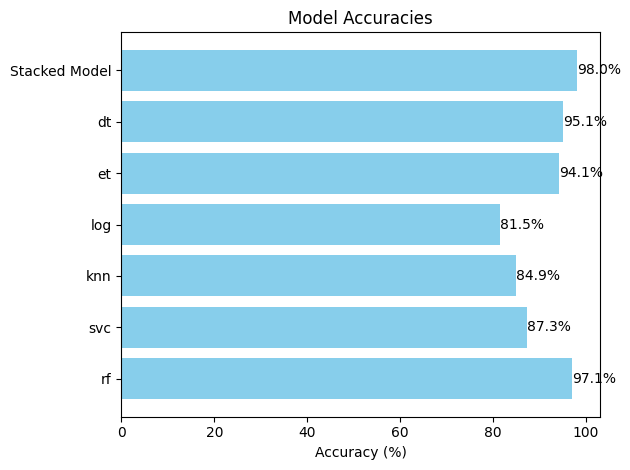

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Evaluate base models
base_model_accuracies = {}
for name, model in base_models:
    model.fit(X_final, y_final)
    y_pred_base = model.predict(X_test_scaled)  # Use X_test_scaled for consistency
    accuracy = accuracy_score(y_test, y_pred_base) * 100  # Convert to percentage
    base_model_accuracies[name] = accuracy

# Evaluate the stacked model
y_pred_stacked = stacked_model.predict(X_test_scaled)  # Use X_test_scaled for consistency
stacked_accuracy = accuracy_score(y_test, y_pred_stacked) * 100  # Convert to percentage
base_model_accuracies['Stacked Model'] = stacked_accuracy

# Plot Accuracy
plt.figure()
names = list(base_model_accuracies.keys())
scores = list(base_model_accuracies.values())
bars = plt.barh(names, scores, color='skyblue')

# Add percentage labels to bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%',
             va='center', ha='left', color='black')

plt.xlabel('Accuracy (%)')
plt.title('Model Accuracies')
plt.tight_layout()
plt.show()


## 5.2 Precision, Recall, and F1-Score Metrics

The precision, recall, and F1-score for each model are summarized in a table. Precision reflects the proportion of true positive predictions among all positive predictions, while recall indicates the model's ability to identify actual positives. The F1-score combines precision and recall into a single metric. The table shows these metrics rounded to two decimal places, with the stacked model showing the highest scores across all metrics, underscoring its effectiveness in classification tasks.








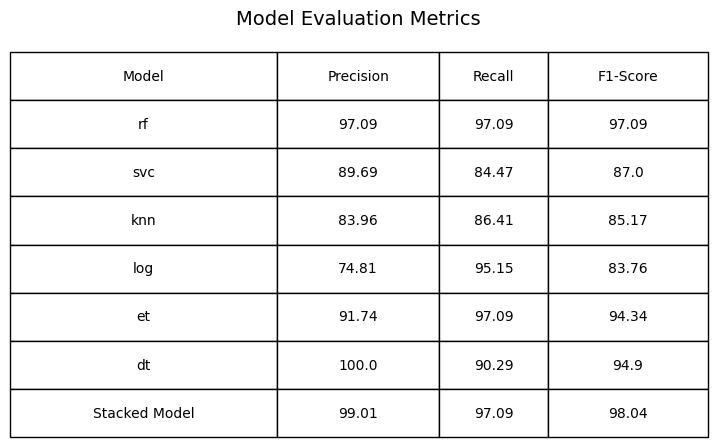

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize dictionaries to store metrics
metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Evaluate base models
for name, model in base_models:
    model.fit(X_final, y_final)
    y_pred_base = model.predict(X_test_scaled)  # Use X_test_scaled for consistency
    precision = round(precision_score(y_test, y_pred_base) * 100, 2)  # Convert to percentage and round
    recall = round(recall_score(y_test, y_pred_base) * 100, 2)  # Convert to percentage and round
    f1 = round(f1_score(y_test, y_pred_base) * 100, 2)  # Convert to percentage and round
    metrics['Model'].append(name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)

# Evaluate the stacked model
y_pred_stacked = stacked_model.predict(X_test_scaled)  # Use X_test_scaled for consistency
precision_stacked = round(precision_score(y_test, y_pred_stacked) * 100, 2)  # Convert to percentage and round
recall_stacked = round(recall_score(y_test, y_pred_stacked) * 100, 2)  # Convert to percentage and round
f1_stacked = round(f1_score(y_test, y_pred_stacked) * 100, 2)  # Convert to percentage and round
metrics['Model'].append('Stacked Model')
metrics['Precision'].append(precision_stacked)
metrics['Recall'].append(recall_stacked)
metrics['F1-Score'].append(f1_stacked)

# Create DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Plot table
fig, ax = plt.subplots(figsize=(9, 5))  # Adjust the size of the figure
ax.axis('tight')
ax.axis('off')
table_data = metrics_df.values
table = ax.table(cellText=table_data, colLabels=metrics_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# Adjust font size and scale
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3])

plt.title('Model Evaluation Metrics', fontsize=14, pad=20)
plt.show()


# 6. Model Saving

In this stage, the trained machine learning models are saved to disk to facilitate future use without requiring re-training. For this purpose, the Python pickle library is utilized. pickle is a standard library in Python that enables serialization and deserialization of Python objects. It converts the trained model into a byte stream, which can be stored as a file and later reconstructed into the original model.

The process involves:

* Serialization: Using pickle, the trained model is serialized into a binary format and saved to a file. This allows the model to be stored efficiently and loaded later for predictions or further evaluation.

* Deserialization: When needed, the model can be loaded back into memory from the saved file using pickle. This restores the model to its original state, enabling its use in generating predictions on new data.

In [16]:
import pickle
from sklearn.preprocessing import StandardScaler

# Save the model and scaler
with open('heart.pkl', 'wb') as file:
    pickle.dump({
        'model': stacked_model,
        'scaler': scaler
    }, file)


In [30]:
import pickle
import pandas as pd
import numpy as np

def predict_heart_disease_risk(input_features):
    try:
        # Load model, scaler, and trained columns from the pickle file
        with open('heart.pkl', 'rb') as file:
            data = pickle.load(file)

        model = data['model']
        scaler = data['scaler']
        trained_columns = data['columns']  # List of columns used during training

        # Step 1: Convert input features into DataFrame
        input_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach',
                         'oldpeak', 'slope', 'ca', 'thal', 'fbs', 'restecg', 'exang']
        input_df = pd.DataFrame([input_features], columns=input_columns)

        # Debug: Check the DataFrame after input conversion
        print("Initial Input DataFrame:")
        print(input_df)

        # Step 2: Apply one-hot encoding for categorical variables
        input_df = pd.get_dummies(input_df, columns=['cp', 'restecg', 'slope', 'ca', 'thal'])

        # Debug: Check the DataFrame after one-hot encoding
        print("After One-Hot Encoding:")
        print(input_df.columns)  # Print column names to check

        # Step 3: Handle missing columns (columns that were present during training but not in input)
        for col in trained_columns:
            if col not in input_df.columns:
                input_df[col] = 0

        # Debug: Check the DataFrame after handling missing columns
        print("After Handling Missing Columns:")
        print(input_df.columns)  # Print column names to check

        # Step 4: Reorder columns to match the order used during training
        input_df = input_df[trained_columns]

        # Debug: Check the DataFrame after reordering columns
        print("After Reordering Columns:")
        print(input_df.columns)  # Print column names to check

        # Step 5: Standardize continuous features using the scaler
        input_df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = scaler.transform(
            input_df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
        )

        # Debug: Check the DataFrame after scaling
        print("After Scaling:")
        print(input_df)

        # Step 6: Check if the input matches the model's expected shape
        print("Final Input Shape:", input_df.shape)
        print("Expected Shape:", (1, len(trained_columns)))

        # Step 7: Make prediction
        prediction = model.predict(input_df)
        suggestion = "🟢 Low Risk: Maintain a healthy lifestyle." if prediction[0] == 0 else "🔴 High Risk: Recommend further tests."

        return {
            "prediction": int(prediction[0]),
            "message": f"Heart Disease Risk: {'Low' if prediction[0] == 0 else 'High'}",
            "suggestion": suggestion
        }

    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

# 🎯 Example Usage
if __name__ == "__main__":
    # Sample input with 13 features (replace with your own test data)
    test_input = [58, 1, 0, 140, 211, 165, 1.0, 2, 0, 2, 0, 1, 0]

    result = predict_heart_disease_risk(test_input)
    print("🧠 Test Prediction Result:")
    print(result)


🧠 Test Prediction Result:
{'error': 'Prediction failed: Ran out of input'}
